In [89]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score

from scipy.stats import entropy
import random

import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

In [90]:

def multiply_weight(X,w):
    return np.dot(X,w)

def generate_particle(num_parameters):
    '''
    we generate num_parameters parameters with values between 0 and 1 random uniform
    '''
    particle=np.array([np.random.uniform() for i in range(num_parameters)])
    return particle

def generate_n_particles(n,num_parameters):
    particles=[]
    for i in range(n):
        particles.append(generate_particle(num_parameters))
    return np.array(particles)

In [91]:
def get_entropy_from_groups(new_entropies,count_items):
    overall_new_entropy = 0
    
    # Calculating the total number of items
    total_items = sum(count_items)
    
    for i in range(len(new_entropies)):
        # Calculating the proportion of items in the current partition
        proportion = count_items[i] / total_items
        
        # Adding the entropy of the current partition weighted by its proportion to the overall new entropy
        overall_new_entropy += new_entropies[i] * proportion
        
    return overall_new_entropy    


def calc_entropy_from_probabilities(list_probas):
    '''
    list_probas is the list of probabiities
    the formula for entropy is
    sum(-proba*log(proba))
    
    '''
    
    entropy_value = 0

    for proba in list_probas:
        # If the probability is not zero
        if proba != 0:
            entropy_value += -proba * np.log(proba)
     
    return entropy_value

def calculate_probabilities(list_labels, uniq_labels):
    '''
    this function calculates the probabilities of each label in the list of labels
    it is calculated by number of labels in class A/all labels
    number of labels in class B/all labels
    and so on
    '''
    
    # A dictionary to store the probabilities
    probabilities = dict.fromkeys(uniq_labels, 0)
    
    # Total number of labels
    total_labels = len(list_labels)
    
    for label in uniq_labels:
        # Counting the number of times the label occurs in the list
        count = list_labels.count(label)
        
        # Calculating the probability of the label
        probability = count / total_labels
        
        # Storing the calculated probability in the dictionary
        probabilities[label] = probability
        
    return probabilities    

def objective_function(X,y,particle):
    '''
    this is binary classification objective
    using entropy
    '''
    res=multiply_weight(X,particle[0:X.shape[1]])
#     print(res.shape)
    res = (res-np.min(res))/(np.max(res)-np.min(res))

    # make two groups
    group1=[]
    group2=[]

    for i in range(res.shape[0]):
    #     print(i,res[i],particle[-1])
        if res[i]<particle[-1]:
            group1.append(y[i])
        else:
            group2.append(y[i])



    proba_gr1=calculate_probabilities(group1,np.unique(group1).tolist())
    proba_gr1=list(proba_gr1.values()) 
    entropy_group1=calc_entropy_from_probabilities(proba_gr1)
    count_group1=len(proba_gr1)

    
    proba_gr2=calculate_probabilities(group2,np.unique(group2).tolist())
    proba_gr2=list(proba_gr2.values()) 
    entropy_group2=calc_entropy_from_probabilities(proba_gr2)
    count_group2=len(proba_gr2)


#     print("entropies",entropy_group1,entropy_group2)
    new_entropies=[entropy_group1,entropy_group2]
    count_items=[count_group1,count_group2]
    overall_new_entropy=get_entropy_from_groups(new_entropies,count_items)

#     print(overall_new_entropy)
    return overall_new_entropy
    
    
    
# def objective_function(X,y,particle):
#     '''
#     this is binary classification objective
#     using (1-accuracy)
#     '''
#     res=multiply_weight(X,particle[0:X.shape[1]])
# #     print(res)
#     res = (res-np.min(res))/(np.max(res)-np.min(res))
# #     print(res)
#     res[res<particle[-1]]=0
#     res[res>=particle[-1]]=1
# #     print(res)
#     acc=accuracy_score(y,res)
# #     print(acc)
#     loss=1-acc
    
#     return loss
    
    

In [92]:
def update_velocity_of_particle(particle,velocity, best_particle, gbest_particle, w_min=0.5, max=1.0, c=0.1):
    new_vel=np.array([0.0 for i in range(particle.shape[0])])
    # Randomly generate r1, r2 and inertia weight from normal distribution
    r1 = random.uniform(0,max)
    r2 = random.uniform(0,max)
    w = random.uniform(w_min,max)
    c1=c
    c2=c
    # Calculate new velocity    
    for i in range(new_vel.shape[0]):
        component1=w*velocity[i]
        component2=c1*r1*(best_particle[i]-particle[i])
        component3=c2*r2*(gbest_particle[i]-particle[i])
#         print(component1,component2,component3)
        new_vel[i]= component1+component2 +component3
#         print(new_vel[i])
#     print(new_vel)
    return new_vel


def update_position(particle, velocity):
  # Move particles by adding velocity
    new_particle = particle + velocity
    return new_particle

### Load data

In [93]:
# Change dataset here
test_size=0.33

# for algeria forest fire data
df=pd.read_csv("/content/Cryotherapy (1).csv")

df.head()

X=df.iloc[:,3:-1].values
y=df.iloc[:,-1].values




# for breast cancer
# bc_data = datasets.load_breast_cancer()
# X = bc_data.data
# y = bc_data.target

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=test_size, random_state=42)


# normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
print(X_train[0],y_train[0])
print(X_test[0],y_test[0])

(60, 3) (60,) (30, 3) (30,)
[0.18181818 1.         0.19571046] 0
[0.36363636 0.         0.04155496] 0


In [94]:
num_particles=5
particles=generate_n_particles(num_particles,X_train.shape[1]+1)
particle=particles[0]
objective_function(X_train,y_train,particle)


0.4557362007079707

### Train and test model

Train loss at the beginning 0.4557362007079707
Test Loss at the beginning 0.6875549038313742
Train Loss at end 0.4557362007079707
Test Loss at end 0.6875549038313742


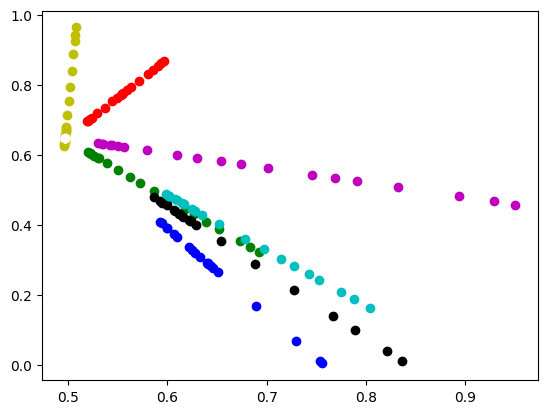

In [95]:
colors=['b','g','r','c','m','y','k','w']

# initialization

num_particles=25
particles=generate_n_particles(num_particles,X_train.shape[1]+1)
particles_best=deepcopy(particles)
gbest_particle=particles[0]



velocities = [[0.0 for j in range(particles.shape[1])] for i in range(particles.shape[0])]


for i in range(particles.shape[0]):
    particle=particles[i]
    loss=objective_function(X_train,y_train,particle)
    loss_best_this_particle=objective_function(X_train,y_train,particles_best[i])
    if loss<loss_best_this_particle:
        particles_best[i]=particle
    loss_best_global=objective_function(X_train,y_train,gbest_particle)
    if loss<loss_best_global:
        gbest_particle=particle

print("Train loss at the beginning",objective_function(X_train,y_train,gbest_particle))
print("Test Loss at the beginning",objective_function(X_test,y_test,gbest_particle))



# run the PSO

# perform PSO here
num_epochs=20

train_losses=[[] for i in range(particles.shape[0])]

for epoch in range(num_epochs):
    for i in range(particles.shape[0]):
        
        particle=particles[i]
        if i <len(colors):
            plt.scatter(particle[0],particle[-1],color=colors[i])
        
        velocity=velocities[i]
        best_particle=particles_best[i]
        # Update the velocity of each particle
        new_vel=update_velocity_of_particle(particle,velocity, best_particle, gbest_particle)
        velocities[i]=new_vel
        particles[i]=update_position(particle, new_vel)
#         print("particle ",i,"threshold",particles[i][-1])



    # after all particles have been updated
    # time to update the bests
    for i in range(particles.shape[0]):
#         print("epoch",epoch,"particle",i)
        particle=particles[i]
        loss=objective_function(X_train,y_train,particle)
        train_losses[i].append(loss)
        loss_best_this_particle=objective_function(X_train,y_train,particles_best[i])
        if loss<loss_best_this_particle:
            particles_best[i]=particle
        loss_best_global=objective_function(X_train,y_train,gbest_particle)
        if loss<loss_best_global:
            gbest_particle=particle

            
print("Train Loss at end",objective_function(X_train,y_train,gbest_particle))
print("Test Loss at end",objective_function(X_test,y_test,gbest_particle))

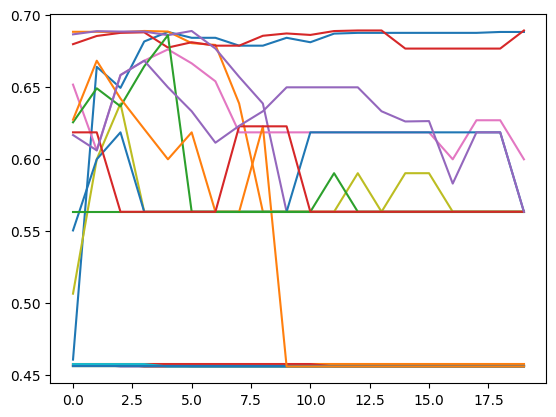

In [96]:
for i in range(len(train_losses)):
    plt.plot(train_losses[i])

In [97]:
res_train=multiply_weight(X_train,gbest_particle[:-1])
min_res_train=np.min(res_train)
max_res_train=np.max(res_train)
range_res_train=(max_res_train-min_res_train)
res_test=multiply_weight(X_test,gbest_particle[:-1])
res_test=(res_test-min_res_train)/range_res_train

threshold=gbest_particle[-1]
y_hat=[]

for i in range(res_test.shape[0]):
    if res_test[i]<threshold:
        y_hat.append(0)
    else:
        y_hat.append(1)

In [98]:
print("accuracy after PSO single level",accuracy_score(y_hat,y_test))

accuracy after PSO single level 0.5


In [99]:
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=4)
decision_tree = decision_tree.fit(X_train,y_train)
print("Accuracy after decision tree", accuracy_score(decision_tree.predict(X_test),y_test))

Accuracy after decision tree 0.8333333333333334
